# Classification by Wine Type

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
red_wine = pd.read_csv('data/winequality-red.csv')
white_wine = pd.read_csv('data/winequality-white.csv', sep=';')

## EDA

In [3]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Looking at quality scores

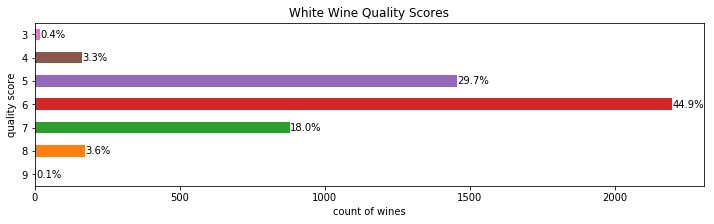

In [5]:
def plot_quality_scores(df, kind):
    ax = df.quality.value_counts().sort_index(
        ascending=False
    ).plot.barh(title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3))
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/4, 
            f'{bar.get_width()/df.shape[0]:.1%}'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

plot_quality_scores(white_wine, 'white')

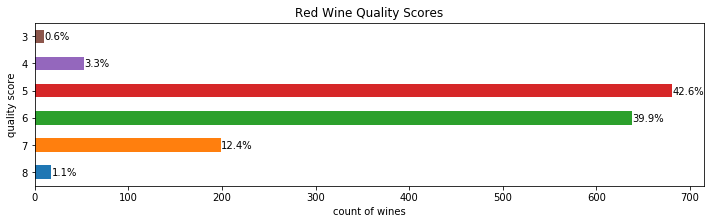

In [6]:
plot_quality_scores(red_wine, 'red')

### Combining red and white wine data

In [7]:
wine = pd.concat([
    white_wine.assign(kind='white'), red_wine.assign(kind='red')
])
wine.sample(5, random_state=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kind
848,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,9.8,5,red
2529,6.6,0.42,0.13,12.8,0.044,26.0,158.0,0.99772,3.24,0.47,9.0,5,white
131,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,red
244,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red
1551,6.6,0.19,0.99,1.2,0.122,45.0,129.0,0.99360,3.09,0.31,8.7,6,white


No null data:

In [8]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 1598
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
kind                    6497 non-null object
dtypes: float64(11), int64(1), object(1)
memory usage: 685.2+ KB


We have more whites than reds:

In [9]:
wine.kind.value_counts()

white    4898
red      1599
Name: kind, dtype: int64

We want to understand if chemical properties can be used to determine wine type. Unfortunately, `describe()` gives a very long output, so we need a visualization to compare the wines this way:

In [10]:
wine.drop(columns='quality').groupby('kind').describe()

alcohol                                                  chlorides  \
        count       mean       std  min  25%   50%   75%   max     count   
kind                                                                       
red    1599.0  10.422983  1.065668  8.4  9.5  10.2  11.1  14.9    1599.0   
white  4898.0  10.514267  1.230621  8.0  9.5  10.4  11.4  14.2    4898.0   

                 ...  total sulfur dioxide        volatile acidity            \
           mean  ...                   75%    max            count      mean   
kind             ...                                                           
red    0.087467  ...                  62.0  289.0           1599.0  0.527821   
white  0.045772  ...                 167.0  440.0           4898.0  0.278241   

                                               
            std   min   25%   50%   75%   max  
kind                                           
red    0.179060  0.12  0.39  0.52  0.64  1.58  
white  0.100795  0.08  0.21  0.26  0.32  1.10  

[2 rows x 88 columns]

### How do chemical properties of the wine correlate to each other and the wine type?
It's important to perform an in-depth exploration of the data before modeling. This includes consulting domain experts, looking for correlations between variables, examining distributions, etc. The visualizations covered in chapters [5](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/tree/master/ch_05) and [6](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/tree/master/ch_06) will prove indispensible for this process. One such visualization is the heatmap. In order to predict if the wine is red or white, we would look for correlations between chemical properties and wine type. We would also try to see if there is a difference in the distribution of our variables for white versus red wines. Some other helpful plot types include box plots, pair plots, and the scatter matrix. 

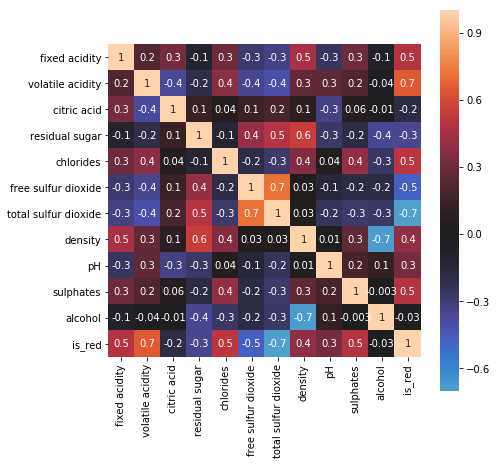

In [11]:
fig = plt.figure(figsize=(7, 7))
sns.heatmap(
    wine.drop(columns='quality').assign(
        is_red=lambda x: np.where(x.kind == 'red', 1, 0)
    ).corr(), center=0, square=True, annot=True, fmt='.1g'
)

### Comparison of Red and White Wines by Their Chemical Properties
This visualization will be easier to digest than the output of `describe()`:

Text(0.5, 0.98, 'Comparing Chemical Properties of Red and White Wines')

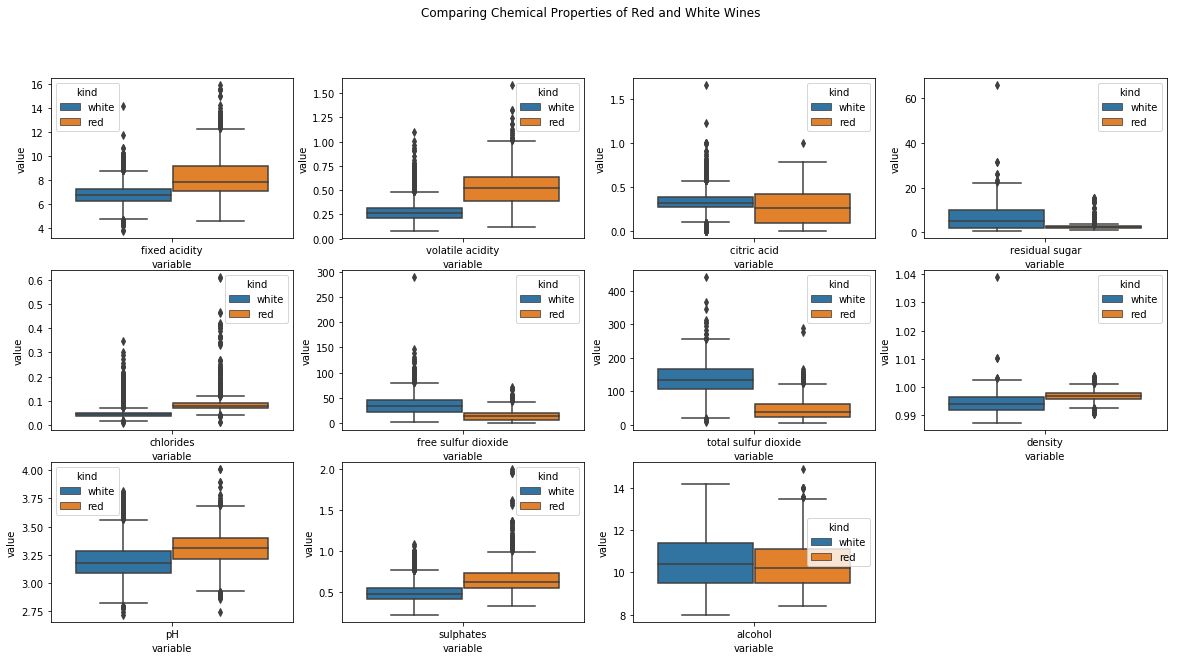

In [12]:
import math

chemical_properties = [col for col in wine.columns if col not in ['quality', 'kind']]
melted = wine.drop(columns='quality').melt(id_vars=['kind'])

fig, axes = plt.subplots(math.ceil(len(chemical_properties) / 4), 4, figsize=(20, 10))
axes = axes.flatten()

for prop, ax in zip(chemical_properties, axes):
    sns.boxplot(
        data=melted[melted.variable.isin([prop])], 
        x='variable', y='value', hue='kind', ax=ax
    )
    
# remove the extra subplots
for ax in axes[len(chemical_properties):]:
    ax.remove()
    
plt.suptitle('Comparing Chemical Properties of Red and White Wines')

## Classification of Red and White Wines
1. separate x and y
2. get the training and testing set
3. build a pipeline with standard scaler followed by logistic regression and fit the model

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1
wine_y = np.where(wine.kind == 'red', 1, 0)
wine_X = wine.drop(columns=['quality', 'kind'])

# 2
w_X_train, w_X_test, w_y_train, w_y_test = train_test_split(
    wine_X, wine_y, test_size=0.25, random_state=0, stratify=wine_y
)

# 3
white_or_red = Pipeline([
    ('scale', StandardScaler()), ('lr', LogisticRegression(solver='lbfgs', random_state=0))
]).fit(w_X_train, w_y_train)

4. make predictions

In [14]:
kind_preds = white_or_red.predict(w_X_test)

5. evaluate predictions

We can use a confusion matrix to see how the model's predictions align with the actual class labels. The model only made 13 incorrect predictions; we will look into these in [chapter 10](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_10/wine.ipynb):

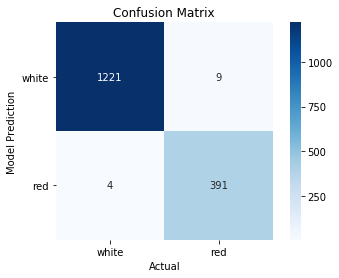

In [15]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(w_y_test, kind_preds, ['white', 'red'])

Precision, recall, and F1 score all look good with this model:

In [16]:
from sklearn.metrics import classification_report
print(classification_report(w_y_test, kind_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1225
           1       0.99      0.98      0.98       400

   micro avg       0.99      0.99      0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



### ROC Curves
Visualize model performance using true positive rates and false positive rates. The area under the curve is on [0, 1] with 1 being the best. This visualization allows us to compare our model to the baseline of random guessing (AUC of 0.5), as well as, other models:

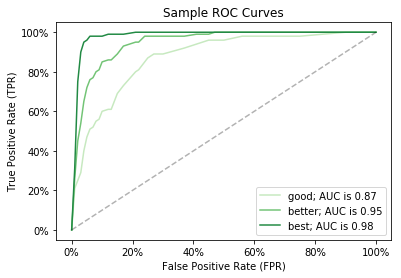

In [17]:
from matplotlib import ticker
from sklearn.metrics import auc

data = pd.read_csv('data/sample_roc_curves.csv')

ax = sns.lineplot(
    data=data, hue='label', x='x', y='y', palette='Greens'
)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)

# formatting 
ax.set_title('Sample ROC Curves')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')

handles, labels = ax.get_legend_handles_labels()
for i, label in enumerate(labels[1:]):
    curve_data = data.query(f'label == "{label}"')
    labels[1 + i] = f'{label}; AUC is {auc(curve_data.x, curve_data.y):.2}'
ax.legend(handles=handles[1:], labels=labels[1:])

ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ROC curves are also called sensitivity-specificity plots since they plot sensitivity (TPR) versus 1-specificity (FPR). They include all sections of the confusion matrix, which is why in cases of class balance, ROC curves are optimistic of performance:

Text(0.5, 1.0, 'Portion of Confusion Matrix Considered')

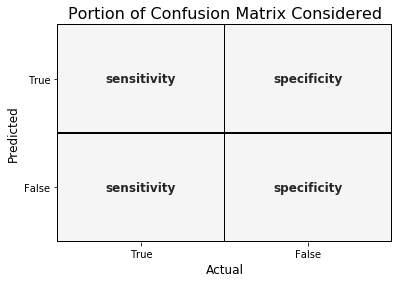

In [18]:
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np

ax = sns.heatmap(
    np.array([[1, 0], [1, 0]]), cbar=False, cmap=ListedColormap(['whitesmoke', 'whitesmoke']),
    annot=np.array([
        ['sensitivity', 'specificity'], 
        ['sensitivity', 'specificity']
    ]), fmt='', annot_kws={'size': 12, 'weight': 'bold'}, linewidths=0.3, linecolor='black'
)
ax.set_xticklabels([True, False])
ax.set_xlabel('Actual', fontsize=12)
ax.set_yticklabels([True, False], rotation=0)
ax.set_ylabel('Predicted', fontsize=12)
ax.set_title('Portion of Confusion Matrix Considered', fontsize=16)

This model performs very well, the area under the curve (AUC) is nearly 1:

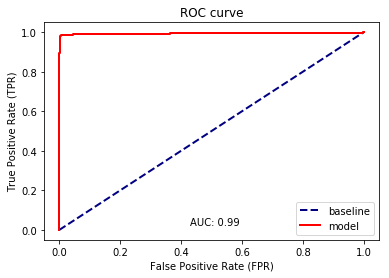

In [19]:
from ml_utils.classification import plot_roc

plot_roc(w_y_test, white_or_red.predict_proba(w_X_test)[:,1])

### Precision-recall curves
When faced with class imbalance, we use precision-recall curves since ROC curves will be optimistic of model performance. AP is the weighted average precision and AUC is the area under the curve once again on [0, 1]. The baseline is now the percentage of observations belonging to the positive class. Values below this line are worse than random:

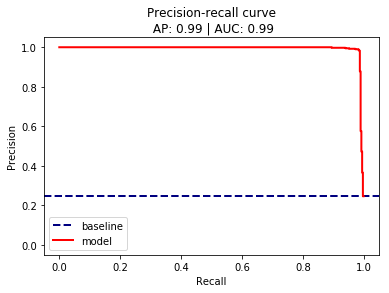

In [20]:
from ml_utils.classification import plot_pr_curve

plot_pr_curve(w_y_test, white_or_red.predict_proba(w_X_test)[:,1])